# Importing Necessary Libraries

In [91]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

from timeit import default_timer as timer
from pathlib import Path
import opendatasets as od
from tqdm.auto import tqdm

# Setup device agnostic code

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Getting the dataset

In [16]:
if Path(".\\mood-image-dataset").is_dir():
    print("The dataset already exists. Skipping download....")
else:
    print("Downloading the dataset")
    od.download("https://www.kaggle.com/datasets/lavishalakhmani/mood-image-dataset?select=images")

The dataset already exists. Skipping download....


In [17]:
train_dir = Path(".\\mood-image-dataset\\images\\train")
test_dir = Path(".\\mood-image-dataset\\images\\validation")

# Preprocessing the dataset

In [18]:
transform = transforms.Compose([
#     transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

In [19]:
train_data = datasets.ImageFolder(train_dir,transform)
test_data = datasets.ImageFolder(test_dir,transform)
print(f"Length of train dataset = {len(train_data)}")
print(f"Length of test dataset = {len(test_data)}")
img,label=train_data[0]
print(f"Shape of image: {img.shape}")

Length of train dataset = 26921
Length of test dataset = 7066
Shape of image: torch.Size([3, 48, 48])


In [29]:
class_labels = train_data.classes
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Preparing Dataloaders

In [21]:
BATCH_SIZE = 32

train_dataloader=DataLoader(dataset=train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e612db80d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1e612fc0450>)

In [23]:
print(f"Length of training dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of testing dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of training dataloader: 842 batches of 32
Length of testing dataloader: 221 batches of 32


# Visulalizing Images from the dataset

In [24]:
example_img,example_label=next(iter(train_dataloader))
print(example_img.shape)
print(example_label.shape)

torch.Size([32, 3, 48, 48])
torch.Size([32])


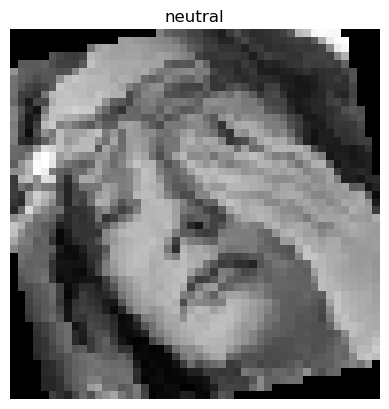

In [72]:
random_idx = torch.randint(0,len(example_label),size=[1]).item()
img,label=example_img[random_idx],example_label[random_idx]
# img=img.permute(1,2,0)
plt.imshow(img.permute(1,2,0))
plt.title(class_labels[label])
plt.axis(False)
plt.show()

# Building the Model

In [135]:
class MoodDetector(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        
        self.block2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*12*12,out_features=output_shape)
        )
        
    def forward(self,x:torch.tensor):
#         print(x.shape)
        x = self.block1(x)
#         print(x.shape)
        x = self.block2(x)
#         print(x.shape)
        x = self.classifier(x)
#         print(x.shape)
        return x

model = MoodDetector(input_shape=3,hidden_units=10,output_shape=len(class_labels)).to(device)
model

MoodDetector(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1440, out_features=7, bias=True)
  )
)

# Setting up loss Function and Optimizer

In [136]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)

In [137]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Functionating the Training and Testing loop

In [161]:
# def train(model, data_loader, loss_fn, optimizer, accuracy_fn, epoch, device):
#     model.train()
#     train_loss, train_acc = 0, 0
#     for X, y in data_loader:
#         X, y = X.to(device), y.to(device)
#         y_pred = model(X)
#         loss = loss_fn(y_pred, y)
#         train_loss += loss.item()
#         train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     train_loss /= len(data_loader)
#     train_acc /= len(data_loader)
#     if epoch % 5 == 0:
#         print(f"Epoch {epoch}: Train loss: {train_loss:.5f}, Train accuracy: {train_acc:.2f}%")
        
        
# def test(data_loader, model, loss_fn, accuracy_fn, epoch, device):
#     model.eval()
#     test_loss, test_acc = 0, 0
#     with torch.no_grad():
#         for X, y in data_loader:
#             X, y = X.to(device), y.to(device)
#             y_pred = model(X)
#             test_loss += loss_fn(y_pred, y).item()
#             test_acc += accuracy_fn(y, y_pred.argmax(dim=1))
#     test_loss /= len(data_loader)
#     test_acc /= len(data_loader)
#     if epoch % 5 == 0:
#         print(f"Epoch {epoch}: Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")


In [162]:
# def train(model:torch.nn.Module,
#           data_loader:torch.utils.data.DataLoader,
#           loss_fn:torch.nn.Module,
#           optimizer:torch.optim.Optimizer,
#           accuracy_fn,
#           epoch:int,
#           device: torch.device = device):
#     train_loss,train_acc = 0,0
#     model.to(device)
    
#     for batch, (X,y) in enumerate(data_loader):
#         X,y = X.to(device),y.to(device)
        
#         y_pred = model(X)
        
#         loss = loss_fn(y_pred,y)
#         train_loss += loss
#         train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     train_loss /= len(data_loader)
#     train_acc /= len(data_loader)
#     if epoch%5==0:
#         print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
            
# def test(data_loader: torch.utils.data.DataLoader,
#          model: torch.nn.Module,
#          loss_fn: torch.nn.Module,
#          accuracy_fn,
#          epoch:int,
#          device: torch.device = device):
#     test_loss, test_acc = 0, 0
#     model.to(device)
#     model.eval() # put model in eval mode
#     # Turn on inference context manager
#     with torch.inference_mode():
#         for X, y in data_loader:
#             X, y = X.to(device), y.to(device)

#             test_pred = model(X)

#             test_loss += loss_fn(test_pred, y)
#             test_acc += accuracy_fn(y_true=y,
#                 y_pred=test_pred.argmax(dim=1)
#             )
#         test_loss /= len(data_loader)
#         test_acc /= len(data_loader)
#         if epoch%5==0:
#             print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [173]:
def train(model:torch.nn.Module,
          data_loader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epoch:int,
          accuracy_fn,
          device:torch.device=device
         ):
    model.to(device)
    model.train() # Setting the model to training mode
    train_loss = 0
    train_acc = 0
    for batch, (X,y) in enumerate(data_loader): # By using this function we are accessing the images and their labels from dataset
        X,y=X.to(device),y.to(device)
        
        # Make the forward pass
        y_pred = model(X)
        
        # Calculate the loss and accuracy
        loss=loss_fn(y_pred,y)
        y_pred_class=y_pred.argmax(dim=1)
        acc=accuracy_fn(y,y_pred_class)
        
        # Accumulate the loss and accuracy
        train_loss+=loss
        train_acc+=acc
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        #Optimizer step 
        optimizer.step()
    
    # Calculating the average training loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    if epoch%5==0:
        print(f"Train Loss: {loss:.2f} | Average Train Loss: {train_loss:.2f} | Train Accuracy: {acc:.2f} | Average Train Accuracy: {train_acc:.2f}")
        

In [174]:
def test(model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        accuracy_fn,
        epoch:int,
        device:torch.device=device):
    model.to(device)
    model.eval() # Setting the model to testing mode
    
    test_loss = 0
    test_acc = 0
    
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X,y = X.to(device),y.to(device)
            
            # Make the forward Pass
            y_pred = model(X)
            
            # Calculate the loss and accuracy 
            loss = loss_fn(y_pred,y)
            y_pred_class = y_pred.argmax(dim=1)
            acc = accuracy_fn(y,y_pred_class)
            
            # Accumulate the loss and accuracy
            test_loss += loss
            test_acc +=acc
        
        # Calculating the average testing loss and accuracy
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        if epoch%5==0:
            print(f"Test Loss: {loss:.2f} | Average Test Loss: {test_loss:.2f} | Test Accuracy: {acc:.2f} | Average Test Accuracy: {test_acc:.2f}")
        

# Function for getting training time

In [175]:
from timeit import default_timer as timer

def print_train_time(start: float,end:float,device: torch.device=True):
  """Prints differecnce between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Training 

In [176]:
def loop(train_dataloader,test_dataloader,model,accuracy_fn,loss_fn,optimizer,device):
    train_time_start = timer()
    epochs = 30
    for epoch in tqdm(range(epochs)):
        if epoch%5==0:
            print(f"Epoch: {epoch}\n---------")

        train(data_loader=train_dataloader,
             model=model,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             epoch=epoch,
             device=device)

        test(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            epoch=epoch,
            device=device)

    train_time_end=timer()
    print_train_time(train_time_start,train_time_end,device)
    return model

In [177]:
mood_detector = loop(train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    model=model,
                    loss_fn=loss_fn,
                    accuracy_fn=accuracy_fn,
                    optimizer=optimizer,
                    device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 2.31 | Average Train Loss: 1.80 | Train Accuracy: 11.11 | Average Train Accuracy: 25.48
Test Loss: 2.20 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 5
---------
Train Loss: 1.79 | Average Train Loss: 1.80 | Train Accuracy: 22.22 | Average Train Accuracy: 25.49
Test Loss: 2.26 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 10
---------
Train Loss: 1.82 | Average Train Loss: 1.80 | Train Accuracy: 22.22 | Average Train Accuracy: 25.49
Test Loss: 2.22 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 15
---------
Train Loss: 1.63 | Average Train Loss: 1.80 | Train Accuracy: 33.33 | Average Train Accuracy: 25.50
Test Loss: 2.31 | Average Test Loss: 1.81 | Test Accuracy: 0.00 | Average Test Accuracy: 25.81
Epoch: 20
---------
Train Loss: 1.80 | Average Train Loss: 1.80 | Train Accuracy: 22.22 | Average Train Accuracy: 25.49
Test Loss: 2.22 | Aver

In [ ]:
MODEL_PATH = Path(".\\")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_NAME = 'mood_detector.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
print(f"Saving model to:- {MODEL_SAVE_PATH}")
torch.save(mood_detector,MODEL_SAVE_PATH)